<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/graph_neural_network_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://keras.io/examples/graph/gnn_citations/

https://habr.com/ru/companies/skillfactory/articles/721838/

In [ ]:
pip install tensorflow

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

In [ ]:
citations_data = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

In [ ]:
citations_data.describe()

,target,source
count,5429.000000,5.429000e+03
mean,115009.455148,5.604759e+05
std,188229.783205,4.710471e+05
min,35.000000,3.500000e+01
25%,6334.000000,7.855200e+04
50%,31353.000000,5.233940e+05
75%,119686.000000,1.113995e+06
max,954315.000000,1.155073e+06


In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers_data = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)

In [ ]:
print("Papers shape:", papers_data.shape)
papers_data.head()

Papers shape: (2708, 1435)


,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [ ]:
class_values = sorted(papers_data["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers_data["paper_id"].unique()))}

papers_data["paper_id"] = papers_data["paper_id"].apply(lambda name: paper_idx[name])
citations_data["source"] = citations_data["source"].apply(lambda name: paper_idx[name])
citations_data["target"] = citations_data["target"].apply(lambda name: paper_idx[name])
papers_data["subject"] = papers_data["subject"].apply(lambda value: class_idx[value])

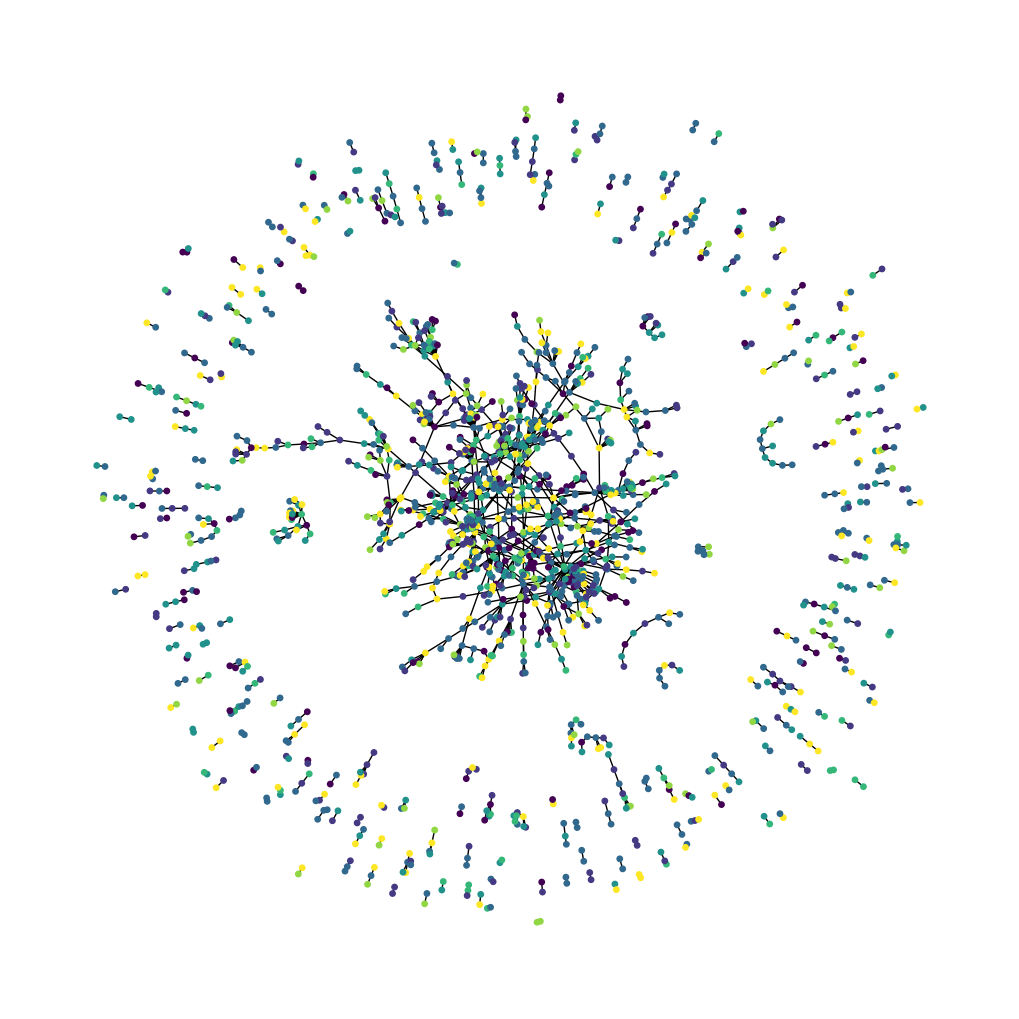

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
colors = papers_data["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations_data.sample(n=1500))
subjects = list(papers_data[papers_data["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [ ]:
feature_names = set(papers_data.columns) - {"paper_id", "subject"}
#feature_names

In [ ]:
edges = citations_data[["source", "target"]].to_numpy().T
print("Edges shape:", edges.shape)

Edges shape: (2, 5429)


In [ ]:
node_features = tf.cast(
    papers_data.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
print("Nodes shape:", node_features.shape)

Nodes shape: (2708, 1433)


<ipython-input-66-8b67d3d1edb9>:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  papers_data.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32


In [ ]:
edge_weights = tf.ones(shape=edges.shape[1])
print("Edges_weights shape:", edge_weights.shape)

Edges_weights shape: (5429,)


In [ ]:
graph_info = (node_features, edges, edge_weights)

# Implement Graph Neural Network class

In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.1
#Deep learning neural networks are trained using the stochastic gradient descent algorithm.
#Stochastic gradient descent is an optimization algorithm that estimates
#the error gradient for the current state of the model using examples
#from the training dataset, then updates the weights of the model using
#the back-propagation of errors algorithm, referred to as simply backpropagation.
#The amount that the weights are updated during training is referred
#to as the step size or the “learning rate.”

dropout_rate = 0.5
#Dropout is a regularization technique for neural network models
#proposed by Srivastava et al. in their 2014 paper
#“Dropout: A Simple Way to Prevent Neural Networks from Overfitting”
#Dropout is a technique where randomly selected neurons are ignored during training.
#They are “dropped out” randomly.
num_epochs = 100
batch_size = 256
#The number of examples from the training dataset used in the estimate
#of the error gradient is called the batch size.

In [ ]:
train_data, test_data = [], []

for _, group_data in papers_data.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (1384, 1435)
Test data shape: (1324, 1435)


In [ ]:
feature_names = set(papers_data.columns) - {"paper_id", "subject"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

<ipython-input-93-07610069752f>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
<ipython-input-93-07610069752f>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_features (InputLayer  [(None, 1433)]               0         []                            
 )                                                                                                
                                                                                                  
 ffn_block1 (Sequential)     (None, 32)                   52804     ['input_features[0][0]']      
                                                                                                  
 ffn_block2 (Sequential)     (None, 32)                   2368      ['ffn_block1[0][0]']          
                                                                                                  
 skip_connection2 (Add)      (None, 32)                   0         ['ffn_block1[0][0]',   

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)


Epoch 1/100
5/5 [==============================] - 7s 183ms/step - loss: 4.6192 - acc: 0.1956 - val_loss: 81.9169 - val_acc: 0.1538
Epoch 2/100
5/5 [==============================] - 0s 44ms/step - loss: 2.4763 - acc: 0.1752 - val_loss: 11.1303 - val_acc: 0.0721
Epoch 3/100
5/5 [==============================] - 0s 39ms/step - loss: 2.0832 - acc: 0.2772 - val_loss: 3.5924 - val_acc: 0.1635
Epoch 4/100
5/5 [==============================] - 0s 47ms/step - loss: 1.8961 - acc: 0.2738 - val_loss: 2.0275 - val_acc: 0.1683
Epoch 5/100
5/5 [==============================] - 0s 43ms/step - loss: 1.8388 - acc: 0.3002 - val_loss: 4.7547 - val_acc: 0.1635
Epoch 6/100
5/5 [==============================] - 0s 37ms/step - loss: 1.8352 - acc: 0.3078 - val_loss: 5.0250 - val_acc: 0.1635
Epoch 7/100
5/5 [==============================] - 0s 39ms/step - loss: 1.7990 - acc: 0.3036 - val_loss: 3.5115 - val_acc: 0.1635
Epoch 8/100
5/5 [==============================] - 0s 42ms/step - loss: 1.7993 - acc: 0

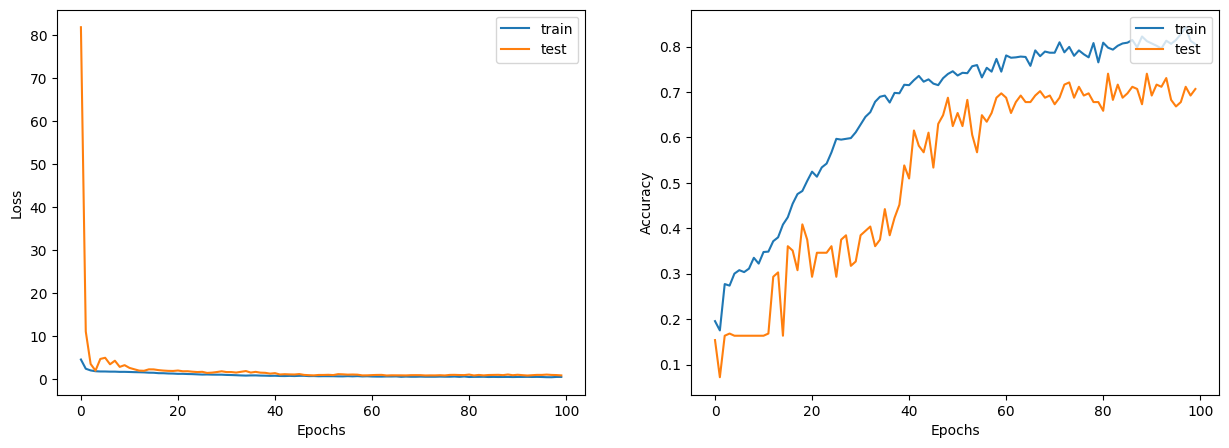

In [ ]:
display_learning_curves(history)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 29.84%


In [ ]:
def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idc, probs in enumerate(probabilities):
        print(f"Instance {instance_idc + 1}:")
        for class_idc, prob in enumerate(probs):
            print(f"- {class_values[class_idc]}: {round(prob * 100, 2)}%")

In [ ]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 [==============================] - 0s 352ms/step
Instance 1:
- 0: 8.69%
- 1: 17.41%
- 2: 29.86%
- 3: 15.34%
- 4: 7.29%
- 5: 7.56%
- 6: 13.86%
Instance 2:
- 0: 8.66%
- 1: 17.52%
- 2: 29.82%
- 3: 15.4%
- 4: 7.27%
- 5: 7.55%
- 6: 13.78%
Instance 3:
- 0: 8.68%
- 1: 17.52%
- 2: 29.74%
- 3: 15.36%
- 4: 7.31%
- 5: 7.6%
- 6: 13.78%
Instance 4:
- 0: 8.69%
- 1: 17.53%
- 2: 29.68%
- 3: 15.42%
- 4: 7.37%
- 5: 7.59%
- 6: 13.72%
Instance 5:
- 0: 8.66%
- 1: 17.49%
- 2: 29.76%
- 3: 15.35%
- 4: 7.34%
- 5: 7.57%
- 6: 13.83%
Instance 6:
- 0: 8.77%
- 1: 17.16%
- 2: 30.01%
- 3: 15.32%
- 4: 7.36%
- 5: 7.6%
- 6: 13.78%
Instance 7:
- 0: 8.67%
- 1: 17.44%
- 2: 29.94%
- 3: 15.33%
- 4: 7.23%
- 5: 7.56%
- 6: 13.82%


In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.00924004  0.11838001  0.03321107  0.1467932   0.15864639 -0.07363249
  -0.00361381]
 [-0.00062743  0.23635292  0.04136644  0.00804665  0.09184396 -0.05120832
   0.07046433]
 [ 0.01781727  0.00764555 -0.03905402  0.06747548  0.0072508   0.07888528
  -0.05646182]], shape=(3, 7), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2708, 32)                52804     
                                                                 
 graph_conv1 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                                 
 graph_conv2 (GraphConvLaye  multiple                  5888      
 r)                                                              
                                                            

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/10
5/5 [==============================] - 9s 298ms/step - loss: 2.3388 - acc: 0.2039 - val_loss: 6.0368 - val_acc: 0.0918
Epoch 2/10
5/5 [==============================] - 1s 145ms/step - loss: 1.9137 - acc: 0.2725 - val_loss: 4.6621 - val_acc: 0.2850
Epoch 3/10
5/5 [==============================] - 1s 156ms/step - loss: 1.8524 - acc: 0.3008 - val_loss: 2.8790 - val_acc: 0.2850
Epoch 4/10
5/5 [==============================] - 1s 140ms/step - loss: 1.8319 - acc: 0.3085 - val_loss: 3.1550 - val_acc: 0.2850
Epoch 5/10
5/5 [==============================] - 1s 139ms/step - loss: 1.8457 - acc: 0.3076 - val_loss: 3.7222 - val_acc: 0.2850
Epoch 6/10
5/5 [==============================] - 1s 144ms/step - loss: 1.8362 - acc: 0.3059 - val_loss: 2.8125 - val_acc: 0.2850
Epoch 7/10
5/5 [==============================] - 1s 147ms/step - loss: 1.8313 - acc: 0.3093 - val_loss: 1.8220 - val_acc: 0.2850
Epoch 8/10
5/5 [==============================] - 1s 160ms/step - loss: 1.8241 - acc: 0.30

In [ ]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers_data.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers_data.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

In [ ]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (2708, 1433)
Original edges shape: (2, 5429)
New node_features shape: (2715, 1433)
New edges shape: (2, 5478)
1/1 [==============================] - 2s 2s/step
Instance 1:
- Case_Based: 4.37%
- Genetic_Algorithms: 75.66%
- Neural_Networks: 12.59%
- Probabilistic_Methods: 2.01%
- Reinforcement_Learning: 1.96%
- Rule_Learning: 2.34%
- Theory: 1.08%
Instance 2:
- Case_Based: 1.23%
- Genetic_Algorithms: 21.68%
- Neural_Networks: 54.3%
- Probabilistic_Methods: 6.87%
- Reinforcement_Learning: 14.91%
- Rule_Learning: 0.43%
- Theory: 0.58%
Instance 3:
- Case_Based: 0.76%
- Genetic_Algorithms: 88.86%
- Neural_Networks: 6.61%
- Probabilistic_Methods: 0.08%
- Reinforcement_Learning: 1.37%
- Rule_Learning: 0.61%
- Theory: 1.71%
Instance 4:
- Case_Based: 7.01%
- Genetic_Algorithms: 29.12%
- Neural_Networks: 22.6%
- Probabilistic_Methods: 13.7%
- Reinforcement_Learning: 1.7%
- Rule_Learning: 14.78%
- Theory: 11.08%
Instance 5:
- Case_Based: 0.06%
- Genetic_Algorithms: 0